<a href="https://colab.research.google.com/github/bnsreenu/python_for_image_processing_APEER/blob/master/tutorial119_multiclass_semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/zpYq1gr1910

**Multiclass semantic segmentation**


The dataset used in this video can be downloaded from the link below. This dataset can be used to train and test machine learning algorithms designed for multiclass semantic segmentation. Please read the Readme document for more information. 
https://drive.google.com/file/d/1HWtBaSa-LTyAMgf2uaz1T9o1sTWDBajU/view?usp=sharing

To annotate your own images, please visit www.apeer.com

In [ ]:
#from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
#Resizing images, if needed
SIZE_X = 128 
SIZE_Y = 128
n_classes=4 #Number of classes for segmentation
num_images = 200  #Total 1600 available

In [ ]:
image_names = glob.glob("/content/drive/MyDrive/Colab Notebooks/data/sandstone/128_patches/images/*.tif")
image_names.sort()
image_names_subset = image_names[0:num_images]
images = [cv2.imread(image, 0) for image in image_names_subset]
image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis = 3)

In [ ]:
mask_names = glob.glob("/content/drive/MyDrive/Colab Notebooks/data/sandstone/128_patches/masks/*.tif")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)


In [ ]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (200, 128, 128, 1)
Mask data shape is:  (200, 128, 128)
Max pixel value in image is:  255
Labels in the mask are :  [1 2 3 4]


In [ ]:
#Encode labels to 0, 1, 2, 3, ... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = mask_dataset.shape  
mask_dataset_reshaped = mask_dataset.reshape(-1,1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)

np.unique(mask_dataset_encoded)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3])

In [ ]:
mask_dataset_encoded = np.expand_dims(mask_dataset_encoded, axis = 3)
print(mask_dataset_encoded.shape)

(200, 128, 128, 1)


In [ ]:
#Normalize images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler

In [ ]:
#Split training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.2, random_state = 42)

In [ ]:
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))



In [ ]:
print(y_train_cat.shape)

(160, 128, 128, 4)


In [ ]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [ ]:
model = build_unet(input_shape, n_classes=4)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

softmax
Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________

In [ ]:
history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test_cat), 
                    shuffle=False)

Epoch 1/50
60/60 [==============================] - 40s 259ms/step - loss: 0.3228 - accuracy: 0.9091 - val_loss: 27.7621 - val_accuracy: 0.0338
Epoch 2/50
60/60 [==============================] - 14s 234ms/step - loss: 0.1244 - accuracy: 0.9553 - val_loss: 0.8999 - val_accuracy: 0.7886
Epoch 3/50
60/60 [==============================] - 14s 240ms/step - loss: 0.1043 - accuracy: 0.9605 - val_loss: 1.3919 - val_accuracy: 0.7264
Epoch 4/50
60/60 [==============================] - 14s 240ms/step - loss: 0.0979 - accuracy: 0.9625 - val_loss: 1.0386 - val_accuracy: 0.7995
Epoch 5/50
60/60 [==============================] - 15s 246ms/step - loss: 0.0934 - accuracy: 0.9633 - val_loss: 1.3862 - val_accuracy: 0.7157
Epoch 6/50
60/60 [==============================] - 15s 248ms/step - loss: 0.0888 - accuracy: 0.9649 - val_loss: 1.2477 - val_accuracy: 0.7554
Epoch 7/50
60/60 [==============================] - 15s 251ms/step - loss: 0.0858 - accuracy: 0.9658 - val_loss: 1.3460 - val_accuracy: 0.724

In [ ]:
#Save the model for future use
model.save('/content/drive/MyDrive/Colab Notebooks/saved_models/tutorial119_sandstone_50epochs.hdf5')

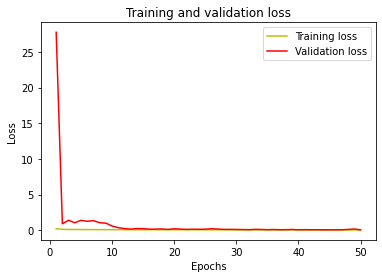

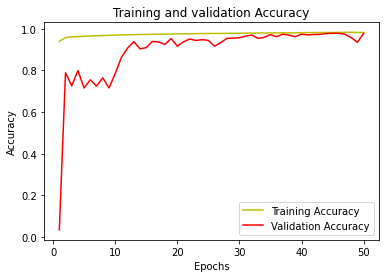

In [ ]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:

        #Load previously saved model
from keras.models import load_model
model = load_model("/content/drive/MyDrive/Colab Notebooks/saved_models/tutorial119_sandstone_50epochs.hdf5", compile=False)

In [ ]:
y_pred=model.predict(X_test)

In [ ]:
y_pred.shape

(40, 128, 128, 4)

In [ ]:
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax.shape

(40, 128, 128)

In [ ]:
#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.92037


In [ ]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)



[[1.03736e+05 7.37000e+02 4.82000e+02 0.00000e+00]
 [3.53700e+03 3.60980e+04 1.87300e+03 0.00000e+00]
 [2.12300e+03 2.98700e+03 4.87613e+05 4.37000e+02]
 [1.00000e+00 0.00000e+00 1.78000e+02 1.55580e+04]]
IoU for class1 is:  0.93780285
IoU for class2 is:  0.79806334
IoU for class3 is:  0.98369956
IoU for class4 is:  0.9619142


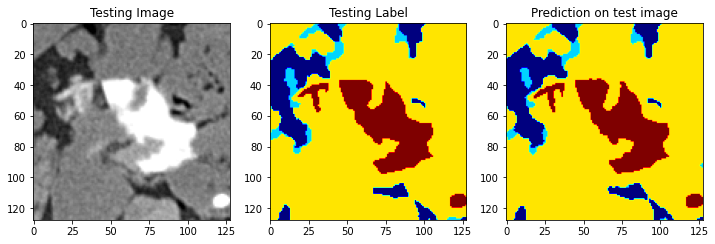

In [ ]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()